In [1]:
from swat import *
from pprint import pprint

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)


In [3]:
from dlpy.layers import * 
from dlpy.applications import *
from dlpy import Model, Sequential
from dlpy.utils import *
from dlpy.splitting import two_way_split
from dlpy.lr_scheduler import *
from dlpy.images import *
from dlpy.image_embedding import *
from dlpy.embedding_model import EmbeddingModel

In [4]:
s = CAS('host_name', port_number)
s.sessionprop.setsessopt(caslib='CASUSER', timeout=31535000)

NOTE: 'CASUSER(userid)' is now the active caslib.


+ Elapsed: 0.000319s, user: 0.000164s, sys: 0.000136s, mem: 0.274mb

# Build a triplet model using ResNet18 as the base branch

In [5]:
#build the base model
resnet18_model = ResNet18_Caffe(s,
                                width=224,
                                height=224
                                ,random_flip='HV',
                                #random_crop='RESIZETHENCROP',
                                random_mutation='random'
                                )

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Pooling layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


In [6]:
# define your own embedding layer with 4 neurons
embedding_layer = Dense(n=4, act='identity')
model_tr = EmbeddingModel.build_embedding_model(resnet18_model, model_table='test_tr',
                                              embedding_model_type='triplet', margin=-3.0,
                                              embedding_layer=embedding_layer)

NOTE: Convert the branch model into a functional model.
NOTE: Remove the task layers from the model.
NOTE: Model compiled successfully.


# Train the model with  on-the-fly data generation

In [7]:
from dlpy.model import Gpu
gpu = Gpu(devices=1)

In [8]:
from dlpy.model import Optimizer, MomentumSolver, AdamSolver
solver = AdamSolver(lr_scheduler=StepLR(learning_rate=0.0001, step_size=4), clip_grad_max = 100, clip_grad_min = -100)
optimizer = Optimizer(algorithm=solver, mini_batch_size=8, log_level=2, max_epochs=8, reg_l2=0.0001)

The following argument(s) learning_rate, learning_rate_policy, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


In [9]:
# In this case, a pre-defined data set is not given. 
# When the path option is specified, the fit_embedding_model API will generate the data on-the-fly.
# max_iter defines how many data iterations will be performed
# the returned results contains the training information for each data iteration
# This dataset contains 10680 training images and 3045 testing images
# For training, 4606 images contain the Cat class while 6073 images for Bird
# For testing, 1381 images contain Cat while 1664 images for Bird
# With this on-the-fly data generation, the training images are randomly selected to create the triplets
# max_iter = 15 means this data generation happens 15 times. 
# The model will continue being trained with each new data sample set.
# Within the training for a given data sample set, AdamSolver is used and the model is trained with 8 epochs.
res = model_tr.fit_embedding_model(optimizer=optimizer, n_threads=4, gpu=gpu, seed=1234,record_seed=23435,
                                   path='server_side_train_data_location', 
                                   n_samples=2048, max_iter=15, 
                                   resize_width=224, resize_height=224)

Note: data generation took 15.827910661697388 (s) at iteration 0
NOTE: Training from scratch.
NOTE: Using host_name: 1 out of 4 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 33548364.
NOTE:  The approximate memory cost is 885.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       4.89 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total mini-batch size per thread on each worker is 8.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 32.
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0        0.0001        -0.01969      3.121     8.70
NOTE:  1        0.0001         -0.2635      3.362     5.15
NOTE:  2        0.0001         -0.2548      3.153     5.08
NOTE:  3        0.0001         -0.4092      3.398     5.07
NOTE:  4          1E-5          -0.693      3.583     5.03
NOTE:  5          1E-5         -0.8115      3.673     5

NOTE:  5          1E-5          -1.653      4.489     5.24
NOTE:  6          1E-5          -1.578      4.569     5.08
NOTE:  7          1E-5          -1.699      4.619     5.03
NOTE:  The optimization reached the maximum number of epochs.
NOTE:  The total time is      43.91 (s).
NOTE: Cloud Analytic Services dropped table ImageData_ckYJub from caslib CASUSER(userid).
Note: data generation took 11.273741960525513 (s) at iteration 6
NOTE: Training based on existing weights.
NOTE: Using host_name: 1 out of 4 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 33548364.
NOTE:  The approximate memory cost is 885.00 MB.
NOTE:  Loading weights cost       0.33 (s).
NOTE:  Initializing each layer cost       2.77 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total mini-batch size per thread on each worker is 8.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 32.
NOTE:  Epoch Learning Rate 

NOTE:  4          1E-5          -1.965      5.148     5.09
NOTE:  5          1E-5          -2.015      4.804     5.02
NOTE:  6          1E-5          -2.082      4.891     5.01
NOTE:  7          1E-5          -2.145      5.084     5.16
NOTE:  The optimization reached the maximum number of epochs.
NOTE:  The total time is      44.51 (s).
NOTE: Cloud Analytic Services dropped table ImageData_GfDa6o from caslib CASUSER(userid).
Note: data generation took 12.385794162750244 (s) at iteration 12
NOTE: Training based on existing weights.
NOTE: Using host_name: 1 out of 4 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 33548364.
NOTE:  The approximate memory cost is 885.00 MB.
NOTE:  Loading weights cost       0.28 (s).
NOTE:  Initializing each layer cost       3.53 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total mini-batch size per thread on each worker is 8.
NOTE:  The maximum mini-batch size across all workers

In [10]:
# check the results from the last data iteration
res[-1]

,Descr,Value
0,Model Name,test_tr
1,Model Type,Convolutional Neural Network
2,Number of Layers,163
3,Number of Input Layers,3
4,Number of Output Layers,0
5,Number of Convolutional Layers,63
6,Number of Pooling Layers,6
7,Number of Fully Connected Layers,3
8,Number of Batch Normalization Layers,63
9,Number of Residual Layers,24


# Deploy the model with astore

In [11]:
# When model_type='full', the entire model is deployed. However, in many cases, 
# We only want to deploy one branch to extract the image features.
# Specifying model_type='branch' will automatically select the first branch as the feature extraction model.
# The generated astore file will be stored at the client path.
# This also returns the generated branch model
branch_model = model_tr.deploy_embedding_model(output_format='astore', model_type='branch', 
                                path='client_side_path')

NOTE: Model compiled successfully.
NOTE: Model weights attached successfully!
NOTE: Model astore file saved successfully.


In [12]:
# Note we generate a fake classification model here
# The output layer does not generate any useful results.
# The features from the EmbeddingLayer_0 layer will be output when deploying the above astore model
branch_model.print_summary()

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
0,0,InputLayer_0,input,,,None,"(224, 224, 3)","(0, 0)",0
1,1,Convo.1,convo,"(7, 7)","(2, 2)",Identity,"(112, 112, 64)","(9408, 0)",118013952
2,2,B.N.1,batchnorm,,,Relu,"(112, 112, 64)","(0, 128)",0
3,3,Pool1,pool,"(3, 3)","(2, 2)",Max,"(56, 56, 64)","(0, 0)",0
4,4,R1C2,convo,"(3, 3)","(1, 1)",Identity,"(56, 56, 64)","(36864, 0)",115605504
5,5,R1B2,batchnorm,,,Relu,"(56, 56, 64)","(0, 128)",0
6,6,R1C3,convo,"(3, 3)","(1, 1)",Identity,"(56, 56, 64)","(36864, 0)",115605504
7,7,R1B3,batchnorm,,,Relu,"(56, 56, 64)","(0, 128)",0
8,8,R1C0,convo,"(1, 1)","(1, 1)",Identity,"(56, 56, 64)","(4096, 0)",12845056
9,9,R1B0,batchnorm,,,Identity,"(56, 56, 64)","(0, 128)",0


# Test the astore model using clustering

In [13]:
# load the generated astore file from the client side into CAS
with open('client_side_path_that_contains_the_astore_file', mode='rb') as file: 
    fileContent = file.read()
# load the astore action set    
s.loadactionset('astore')
# upload it to CAS
store_ = sw.blob(fileContent)
s.astore.upload(rstore=dict(name='test_tr_branch', replace=True),store = store_)

NOTE: Added action set 'astore'.
NOTE: 44793765 bytes were uploaded to the table "test_tr_branch" in the caslib "CASUSER(userid)".


+ Elapsed: 0.0715s, user: 0.0283s, sys: 0.043s, mem: 87mb

In [14]:
# check the astore information
# note that the useful image embedding columns are
# _LayerAct_53_0_0_0_ to _LayerAct_53_0_0_3_
# these stores 4 numbers as the learned image embedding vector
s.astore.describe(rstore='test_tr_branch')

[Key]

 Store Key
 
                                         Key
 0  675D854EDD3236CE7952F5258B60ACB193EAC58D

[Description]

 Basic Information
 
          Attribute               Value
 0  Analytic Engine           deeplearn
 1     Time Created  23Jan2020:10:14:25

[InputVariables]

 Input Variables
 
       Name     Length   Role       Type    RawType FormatName
 0  _image_  1000000.0  Input  Varbinary  Character           

[OutputVariables]

 Output Variables
 
                   Name  Length       Type                              Label
 0      P__fake_output_     8.0        Num           Predicted: _fake_output_
 1      I__fake_output_    12.0  Character                Into: _fake_output_
 2  _LayerAct_53_0_0_0_     8.0        Num  Output for Layer embeddinglayer_0
 3  _LayerAct_53_0_0_1_     8.0        Num  Output for Layer embeddinglayer_0
 4  _LayerAct_53_0_0_2_     8.0        Num  Output for Layer embeddinglayer_0
 5  _LayerAct_53_0_0_3_     8.0        Num  Output for Layer embeddinglayer_0

+ Elapsed: 0.975s, user: 0.893s, sys: 0.0797s, mem: 197mb

In [15]:
# load our testing data
my_test_table = ImageTable.load_files(conn=s, path='server_side_test_data_location')

In [16]:
my_test_table.label_freq

,Level,Frequency
Bird,1,1664
Cat,2,1381


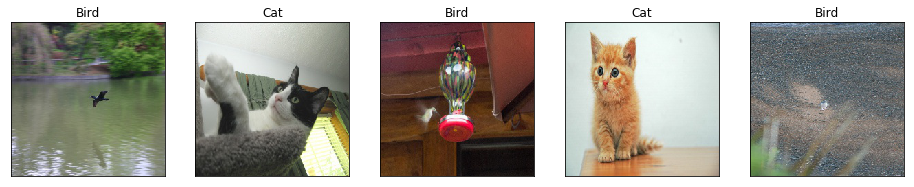

In [17]:
my_test_table.show(randomize=True)

In [18]:
# generate the image embedding by calling the astore.score action with one GPU
s.score(rstore = 'test_tr_branch',
        table = my_test_table,
        nthreads =1,
        copyvars=['_filename_0', '_label_'],
        options=[dict(name='usegpu', value='1'),
                 dict(name='NDEVICES', value='1'), 
                 dict(name='DEVICE0', value='0')
                ],
        out = dict(name='astore_score1_branch_gpu', replace=True))

[OutputCasTables]

             casLib                      Name  Rows  Columns  \
 0  CASUSER(userid)  astore_score1_branch_gpu  3045        8   
 
                                                          casTable  
 0  CASTable('astore_score1_branch_gpu', caslib='CASUSER(userid)')  

[Timing]

 Task Timing
 
                  Task    Seconds   Percent
 0   Loading the Store   0.000039  0.000004
 1  Creating the State   2.647187  0.261649
 2             Scoring   7.469934  0.738331
 3               Total  10.117330  1.000000

+ Elapsed: 10.4s, user: 8.51s, sys: 1.58s, mem: 286mb

In [19]:
# check the generated image embedding
s.fetch(table='astore_score1_branch_gpu', fetchVars=['_LayerAct_53_0_0_0_', '_LayerAct_53_0_0_0_', 
                                                     '_LayerAct_53_0_0_1_', '_LayerAct_53_0_0_2_'],
       to=5)

,_LayerAct_53_0_0_0_,_LayerAct_53_0_0_0_2,_LayerAct_53_0_0_1_,_LayerAct_53_0_0_2_
0,0.634264,0.634264,-3.761376,-0.267680
1,0.807964,0.807964,-2.000060,-0.286563
2,-0.199534,-0.199534,-0.394895,-0.277593
3,0.061049,0.061049,-0.781151,0.337299
4,0.878167,0.878167,-3.697006,0.166331


In [20]:
# use these generated vectors for clustering
feature_list=[]
for i in range(0, 4):
    feature_list.append("_LayerAct_53_0_0_" + str(i) +"_")

In [21]:
s.loadactionset('clustering')
s.kclus(table=dict(name='astore_score1_branch_gpu'),
        maxClusters=2, maxIters=100, standardize='std',
        inputs=feature_list,
        output=dict(casout=dict(name='cluster_results', replace=True),
                   copyvars=['_filename_0', '_label_']))

NOTE: Added action set 'clustering'.
NOTE: Using SEED=247727254.
NOTE: Running for input data for K 2.
NOTE: Clustering is finished. STOPVALUE is satisfied for STOPCRITERION=CLUSTER_CHANGE.


[outputSize]

 {'outputNObs': 3045.0, 'outputNVars': 5}

[NObs]

 Number of Observations
 
                           Type       N
 0  Number of Observations Read  3045.0
 1  Number of Observations Used  3045.0

[ModelInfo]

 Model Information
 
                              RowId                        Parameter  \
 0             Clustering_Algorithm             Clustering Algorithm   
 1               Maximum_Iterations               Maximum Iterations   
 2                   Stop_Criterion                   Stop Criterion   
 3             Stop_Criterion_Value             Stop Criterion Value   
 4                         Clusters                         Clusters   
 5                   Initialization                   Initialization   
 6                             Seed                             Seed   
 7  Distance_For_Interval_Variables  Distance for Interval Variables   
 8                  Standardization                  Standardization   
 9              Interval_Imputation              Interval Imputation   
 
           Setting  
 0         K-means  
 1             100  
 2  Cluster Change  
 3               0  
 4               2  
 5           Forgy  
 6       247727254  
 7       Euclidean  
 8             Std  
 9            None  

[DescStats]

 Descriptive Statistics
 
               Variable      Mean    StdDev
 0  _LayerAct_53_0_0_0_  0.360738  0.723174
 1  _LayerAct_53_0_0_1_ -2.152489  1.389160
 2  _LayerAct_53_0_0_2_ -0.126367  0.438602
 3  _LayerAct_53_0_0_3_  0.018556  1.164241

[WithinClusStats]

 Within Cluster Statistics
 
               Variable  Cluster      Mean    StdDev
 0  _LayerAct_53_0_0_0_        1 -0.779950  0.646705
 1                             2  0.770277  0.616702
 2  _LayerAct_53_0_0_1_        1  0.902598  0.475379
 3                             2 -0.891404  0.406001
 4  _LayerAct_53_0_0_2_        1 -0.119778  1.048627
 5                             2  0.118292  0.934928
 6  _LayerAct_53_0_0_3_        1 -0.855837  0.494473
 7                             2  0.845223  0.555030

[Standardization]

 Standardization
 
               Variable  Location     Scale
 0  _LayerAct_53_0_0_0_  0.360738  0.723174
 1  _LayerAct_53_0_0_1_ -2.152489  1.389160
 2  _LayerAct_53_0_0_2_ -0.126367  0.438602
 3  _LayerAct_53_0_0_3_  0.018556  1.164241

[ClusterSum]

 Cluster Summary
 
    Cluster  Frequency   MinDist   MaxDist   AvgDist          SSE  \
 0        1     1513.0  0.192134  4.796954  1.275730  3006.362257   
 1        2     1532.0  0.142137  3.598539  1.194667  2644.507602   
 
    StdDeviation  NearestClus  DBtwCentroids  
 0      1.409617          2.0       2.927786  
 1      1.313842          1.0       2.927786  

[ClusterCenters]

 Cluster Centroids
 
    _ITERATION_  _CLUSTER_ID_  _LayerAct_53_0_0_0_  _LayerAct_53_0_0_1_  \
 0          5.0           1.0            -0.203301            -0.898636   
 1          5.0           2.0             0.917782            -3.390792   
 
    _LayerAct_53_0_0_2_  _LayerAct_53_0_0_3_  S__LayerAct_53_0_0_0_  \
 0            -0.178902            -0.977845              -0.779950   
 1            -0.074484             1.002599               0.770277   
 
    S__LayerAct_53_0_0_1_  S__LayerAct_53_0_0_2_  S__LayerAct_53_0_0_3_  
 0               0.902598              -0.119778              -0.855837  
 1              -0.891404               0.118292               0.845223  

[IterStats]

 Iteration History
 
    IterationNum  IterationSSE    SSEChange  StopCriterion
 0             0   9735.156567          NaN            NaN
 1             1   5951.002261 -3784.154306       9.096880
 2             2   5669.927762  -281.074499       2.233169
 3             3   5651.962284   -17.965478       0.558292
 4             4   5650.898329    -1.063956       0.098522
 5             5   5650.869859    -0.028470       0.000000

[OutputCasTables]

             casLib             Name Label  Rows  Columns  \
 0  CASUSER(userid)  cluster_results        3045        5   
 
    

In [22]:
# we can get two quite good clusters only using a vector with 4 numbers
# each cluster is only dominated by a single class
s.freq(table=dict(name='cluster_results', groupby='_cluster_id_'), inputs='_label_')

[ByGroupInfo]

 ByGroupInfo
 
    _CLUSTER_ID_ _CLUSTER_ID__f         _key_
 0           1.0              1             1
 1           2.0              2             2

[ByGroup1.Frequency]

 Frequency for CLUSTER_RESULTS
 
                Column CharVar FmtVar  Level  Frequency
 _CLUSTER_ID_                                          
 1             _label_    Bird   Bird      1      238.0
 1             _label_     Cat    Cat      2     1275.0

[ByGroup2.Frequency]

 Frequency for CLUSTER_RESULTS
 
                Column CharVar FmtVar  Level  Frequency
 _CLUSTER_ID_                                          
 2             _label_    Bird   Bird      1     1426.0
 2             _label_     Cat    Cat      2      106.0

+ Elapsed: 0.00998s, user: 0.00373s, sys: 0.0121s, mem: 11.5mb

In [24]:
# close the session
s.endsession()

+ Elapsed: 0.000101s, user: 9.1e-05s, mem: 0.225mb